In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
import scipy.stats
import statsmodels.stats.multitest as mt
from matplotlib.lines import Line2D

import shared_functions

In [2]:
data = joblib.load('joblib/catsNdogs_data.joblib')
data_tax = data.get_taxa(filtered=True)

In [3]:
def draw_boxplot_by_projects(data_phylums,info,name):
    df = data_phylums.merge(info,left_index=True,right_index=True)
    df_melted = pd.melt(df,id_vars=['project_name','Host','Host_type'])
    df_melted['last_tax'] = df_melted.variable.apply(lambda x: x.split(';')[-1])
    plt.figure(figsize=(20,7))
    ax = plt.gca()
    g1 = sns.boxplot(y="value", x="last_tax", hue="project_name",palette=['r']*12+['b']*13,
                    data=df_melted,whis = [5,95],showfliers=False,boxprops=dict(alpha=.8))
    legend_elements = [Line2D([0], [0], color='r', label='cats and dogs projects'),
                       Line2D([0], [0], color='b', label='human projects')]
    g1.legend(loc='center', bbox_to_anchor=(0.5, 1.1), handles=legend_elements, ncol = 2)
    plt.xticks(rotation=45) 
    ax.set_xlabel('')
    ax.set_ylabel('taxon portion of the total')
    plt.title(name)
    plt.show()

In [4]:
def phylums_mv(taxa_df,info,level,draw=False):
    data_phylums = shared_functions.get_phylums(taxa_df,level)
    df = data_phylums.merge(info,left_index=True,right_index=True)
    z = df.groupby(['project_name','Host','Host_type']).agg('median')
    def _mw(df2):
        cat = df2.index.get_level_values(2)
        x = list(df2[cat.isin(['human'])])
        y = list(df2[cat.isin(['catNdog'])])
        try:
            (mw,mw_pval) = scipy.stats.mannwhitneyu(x,y,alternative="two-sided")
            return(mw_pval)
        except:
            return(None)
    phylum_mw_test = z.apply(_mw)
    all_phylums = list(phylum_mw_test.index)
    phylum_mw_test = phylum_mw_test.dropna()
    rj_holm,corr_pvalue_holm,c1,c2 = mt.multipletests(phylum_mw_test, method='holm')
    rj_fdr,corr_pvalue_fdr,c1,c2 = mt.multipletests(phylum_mw_test, method='fdr_bh')
    phylum_mw_test = pd.DataFrame(phylum_mw_test,columns=['mw_pvalue'])
    phylum_mw_test['corr_pvalue_holm'] = corr_pvalue_holm
    phylum_mw_test['rj_holm'] = rj_holm
    phylum_mw_test['corr_pvalue_fdr'] = corr_pvalue_fdr
    phylum_mw_test['rj_fdr'] = rj_fdr
    phylum_mw_test['level']= level
    if (draw):
        draw_cols = list(phylum_mw_test[rj_holm].index)
        draw_boxplot_by_projects(data_phylums[draw_cols],info,shared_functions.get_tax_name_by_level(level))
    res_holm = list(phylum_mw_test[rj_holm].index)
    res_fdr = list(phylum_mw_test[rj_fdr].index)
    #print(phylum_mw_test)
    return(df,(res_holm,res_fdr,all_phylums),phylum_mw_test)

## All phylums distribution by projects
Note the outliers

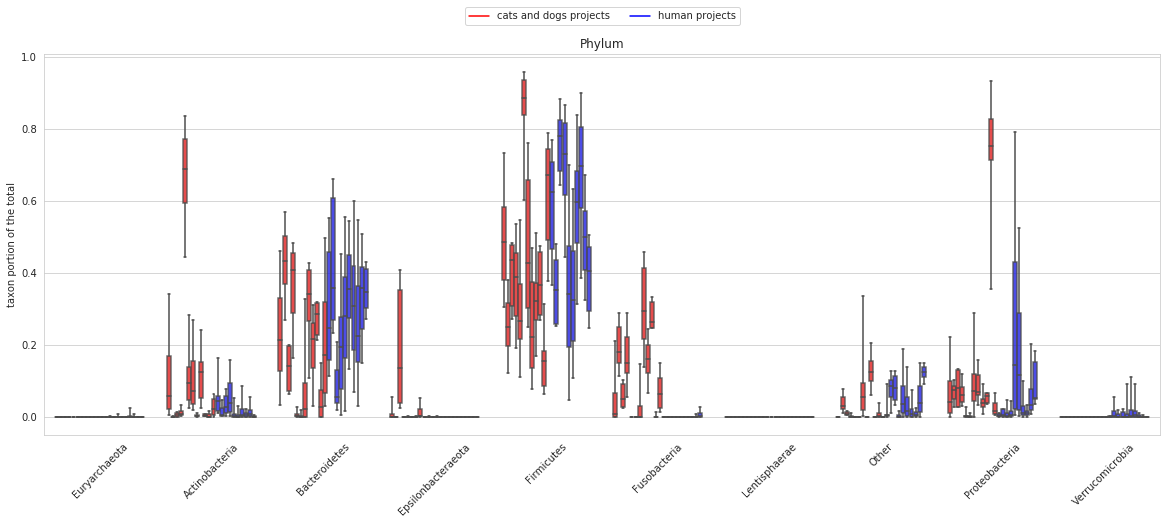

In [5]:
data_phylums = shared_functions.get_phylums(data_tax,1)
draw_boxplot_by_projects(data_phylums,data.info,shared_functions.get_tax_name_by_level(1))

## MW test for Chao diversity index

In [9]:
df = data.info.merge(data.chao,left_index=True,right_index=True)
z = df.groupby(['project_name','Host_type'])['mean_chao'].agg('median').to_frame().reset_index()
x = z.loc[z.Host_type=='catNdog','mean_chao']
y = z.loc[z.Host_type=='human','mean_chao']
z.set_index(keys = ['project_name','Host_type'],inplace=True)
z.columns = ['chao index (project median)']
display(z.sort_values(['Host_type','chao index (project median)']))
print('MW two-sided test catNdog vs. human')
scipy.stats.mannwhitneyu(x,y,alternative="two-sided")

,,chao index (project median)
project_name,Host_type,
PRJDB5398,catNdog,27.000000
PRJNA358232,catNdog,86.000000
PRJNA492898,catNdog,92.633333
PRJNA493249,catNdog,95.150000
PRJNA525542,catNdog,98.045570
PRJNA391562,catNdog,104.975000
PRJNA248757,catNdog,138.276822
PRJNA349988,catNdog,150.992123
PRJNA338653,catNdog,156.599286


MW two-sided test catNdog vs. human


MannwhitneyuResult(statistic=42.0, pvalue=0.24853467917305805)

## MW significant taxa (Holm correction ) on each level, from Phylum to Genus

In [ ]:
bf = {}
mwres = pd.DataFrame()
for i in range(1,6):
    x,y,z = phylums_mv(data_tax,data.info,i,True)
    bf[(i,'best_holm')] = (list(pd.unique(y[0])),False)
    bf[(i,'best_fdr')] = (list(pd.unique(y[1])),False)
    bf[(i,'all')] = (list(pd.unique(y[2])),True)
    tax = shared_functions.get_tax_name_by_level(i)
    print(tax,':',len(pd.unique(y[0])),'significant out of',len(pd.unique(y[2])))
    mwres = pd.concat([mwres,z[z.rj_holm|z.rj_fdr]])

In [ ]:
mwres = mwres.reset_index().rename(columns={'index': 'full_tax_name'})
mwres['last_tax_name'] = mwres.full_tax_name.apply(lambda x: x.split(';')[-1])
mwres['tax_level'] = mwres.level.apply(shared_functions.get_tax_name_by_level)
mwres.sort_values(['level','corr_pvalue_holm','corr_pvalue_fdr'],inplace=True)
mwres = mwres[['full_tax_name','last_tax_name','tax_level','mw_pvalue',
               'corr_pvalue_holm','rj_holm','corr_pvalue_fdr','rj_fdr']]
mwres.to_csv('results/catsNdogs_Table3_mw_test.txt',index=False,sep='\t')

In [ ]:
tax = data_tax.T.reset_index()['index'].to_frame()
tax = pd.concat([tax,tax.apply(lambda x: x[0].split(';'),axis=1,result_type='expand')],axis=1)
tax.set_index('index',inplace=True)
tax.columns = list(map(shared_functions.get_tax_name_by_level,list(tax.columns)))
tax.index.name = 'tax_full_name'
tax.to_csv('results/catsNdogs_Table3_1_taxa_to_mark.txt',sep='\t')

In [ ]:
x=joblib.dump(bf,'joblib/catsNdogs_mw_bf.joblib')